In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
import scipy
import argparse
import plotly.graph_objects as go
import pgeocode
import plotly.express as px

# Image processing
import imageio
import skimage
import skimage.io
import skimage.transform
from skimage.color import rgb2gray

# Tensorflow
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow


#Sklearn
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN as dbs
from sklearn.model_selection import GridSearchCV

RSEED=42
sns.set(style="whitegrid", font='sans-serif', font_scale=1)

# Bee Data Health Status

In [2]:
bee_data = pd.read_csv('../capstone_working/bee_data.csv',
                       parse_dates={'datetime': [1, 2]},
                       dtype={'subspecies': 'category','health': 'category','caste': 'category'})

In [3]:
bee_data.head()

datetime         file        location  zip code subspecies  \
0 2018-08-28 16:07:00  041_066.png  Alvin, TX, USA     77511         -1   
1 2018-08-28 16:07:00  041_072.png  Alvin, TX, USA     77511         -1   
2 2018-08-28 16:07:00  041_073.png  Alvin, TX, USA     77511         -1   
3 2018-08-28 16:07:00  041_067.png  Alvin, TX, USA     77511         -1   
4 2018-08-28 16:07:00  041_059.png  Alvin, TX, USA     77511         -1   

              health  pollen_carrying   caste  
0  hive being robbed            False  worker  
1  hive being robbed            False  worker  
2  hive being robbed            False  worker  
3  hive being robbed            False  worker  
4  hive being robbed            False  worker

In [4]:
bee_data.columns = bee_data.columns.str.replace(' ', '_')

## EDA for the Bee images for Health detection

In [5]:
bee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 8 columns):
datetime           5172 non-null datetime64[ns]
file               5172 non-null object
location           5172 non-null object
zip_code           5172 non-null int64
subspecies         5172 non-null category
health             5172 non-null category
pollen_carrying    5172 non-null bool
caste              5172 non-null category
dtypes: bool(1), category(3), datetime64[ns](1), int64(1), object(2)
memory usage: 182.5+ KB


In [6]:
bee_data.describe()

zip_code
count   5172.000000
mean   68599.910480
std    27101.954146
min     3431.000000
25%    50315.000000
50%    77511.000000
75%    95070.000000
max    95124.000000

### Looking at health and subspecies

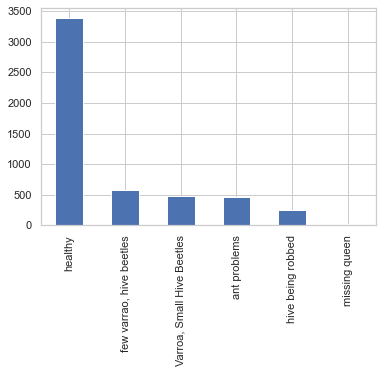

In [7]:
bee_data.health.value_counts().plot(kind='bar')

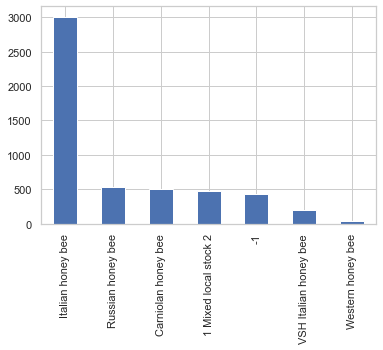

In [8]:
bee_data.subspecies.value_counts().plot(kind='bar')

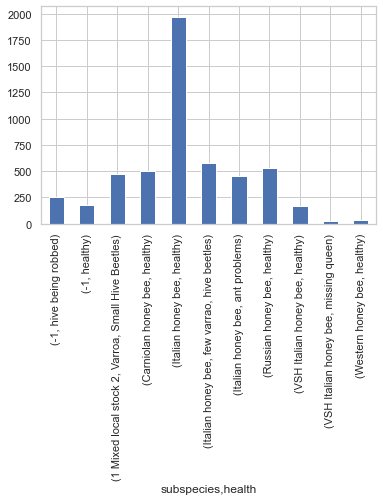

In [9]:
bee_data.groupby('subspecies')['health'].value_counts().plot(kind='bar')

### Looking at the caste of the bees

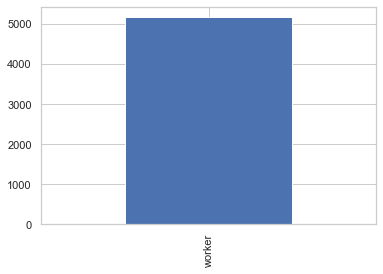

In [10]:
bee_data.caste.value_counts().plot(kind='bar')

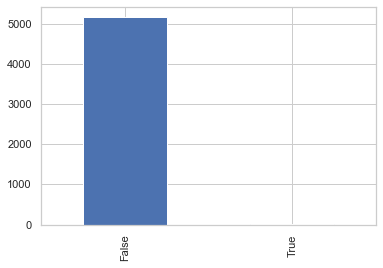

In [11]:
bee_data.pollen_carrying.value_counts().plot(kind='bar')

In [59]:
idx_lst = []
zip_lst = []
zip_data = pgeocode.Nominatim('us')
for idx, zip in bee_data.zip_code.iteritems():
    idx_lst.append(idx)
    zip_lst.append(str(zip))
zip_data = zip_data.query_postal_code(zip_lst)

In [67]:
zip_data.drop(['county_code', 'community_name', 'community_code', 'accuracy'],axis=1, inplace=True)

In [72]:
zip_data.columns = zip_data.columns.str.replace(' ', '_')

In [73]:
zip_data.head()

postal_code country_code place_name state_name state_code county_name  \
0       77511           US      Alvin      Texas         TX    Brazoria   
1       77511           US      Alvin      Texas         TX    Brazoria   
2       77511           US      Alvin      Texas         TX    Brazoria   
3       77511           US      Alvin      Texas         TX    Brazoria   
4       77511           US      Alvin      Texas         TX    Brazoria   

   latitude  longitude  
0    29.412   -95.2515  
1    29.412   -95.2515  
2    29.412   -95.2515  
3    29.412   -95.2515  
4    29.412   -95.2515

In [70]:
bee_data.drop(['location', 'zip_code'], axis=1, inplace=True)

In [74]:
bee_data = pd.concat([
    bee_data, zip_data
],
                         axis=1)

In [118]:
fig = px.scatter_mapbox(bee_data,
                        lat="latitude",
                        lon="longitude",
                        color_discrete_sequence= ['red'],
                        center=dict(lat=40.55, lon=-101.91),
                        zoom=2
                        )
fig.update_layout(mapbox_style="open-street-map") 
fig.show()

### Creating Dummies

In [12]:
bee_data_dum = bee_data.copy()

#### Subspecies

In [ ]:
subspecies_dummies = pd.get_dummies(bee_data_dum.subspecies, drop_first=True)

In [ ]:
subspecies_dummies.columns = subspecies_dummies.columns.str.replace(' ', '_')

#### Pollen Carrying

In [ ]:
pollen_dummies = pd.get_dummies(bee_data_dum.pollen_carrying, drop_first=True, prefix = 'pollen_')

#### Health

In [ ]:
health_dummies = pd.get_dummies(bee_data_dum.health, drop_first=True)

In [ ]:
health_dummies.columns = health_dummies.columns.str.replace(' ', '_')

In [ ]:
health_dummies.missing_queen.value_counts()

In [ ]:
health_dummies.hive_being_robbed.value_counts()

#### Location

In [ ]:
location_dummies = pd.get_dummies(bee_data_dum.location, drop_first=True)

In [ ]:
location_dummies.columns = location_dummies.columns.str.replace(' ', '_')

#### zip code

In [ ]:
zip_dummies = pd.get_dummies(bee_data_dum.zip_code, drop_first=True)

#### caste

In [ ]:
caste_dummies = pd.get_dummies(bee_data_dum.caste)

#### Create new data frame with dummies

In [24]:
drop_columns = [
    'health', 'subspecies', 'pollen_carrying', 'caste', 'location', 'zip_code'
]
bee_data_dum.drop(drop_columns, axis=1, inplace=True)

In [25]:
bee_data_dum = pd.concat([
    bee_data_dum, health_dummies, pollen_dummies, subspecies_dummies,
    caste_dummies, zip_dummies, location_dummies
],
                         axis=1)
bee_data_dum.head()

datetime         file  ant_problems  few_varrao,_hive_beetles  \
0 2018-08-28 16:07:00  041_066.png             0                         0   
1 2018-08-28 16:07:00  041_072.png             0                         0   
2 2018-08-28 16:07:00  041_073.png             0                         0   
3 2018-08-28 16:07:00  041_067.png             0                         0   
4 2018-08-28 16:07:00  041_059.png             0                         0   

   healthy  hive_being_robbed  missing_queen  pollen__True  \
0        0                  1              0             0   
1        0                  1              0             0   
2        0                  1              0             0   
3        0                  1              0             0   
4        0                  1              0             0   

   1_Mixed_local_stock_2  Carniolan_honey_bee  ...  77511  95070  95124  \
0                      0                    0  ...      1      0      0   
1                      0                    0  ...      1      0      0   
2                      0                    0  ...      1      0      0   
3                      0                    0  ...      1      0      0   
4                      0                    0  ...      1      0      0   

   Athens,_GA,_USA  Athens,_Georgia,_USA  Des_Moines,_IA,_USA  Keene,_NH,_USA  \
0                0                     0                    0               0   
1                0                     0                    0               0   
2                0                     0                    0               0   
3                0                     0                    0               0   
4                0                     0                    0               0   

   New_Orleans,_LA,_USA  San_Jose,_CA,_USA  Saratoga,_CA,_USA  
0                     0                  0                  0  
1                     0                  0                  0  
2                     0                  0                  0  
3                     0                  0                  0  
4                     0                  0                  0  

[5 rows x 28 columns]

### Heatmaps

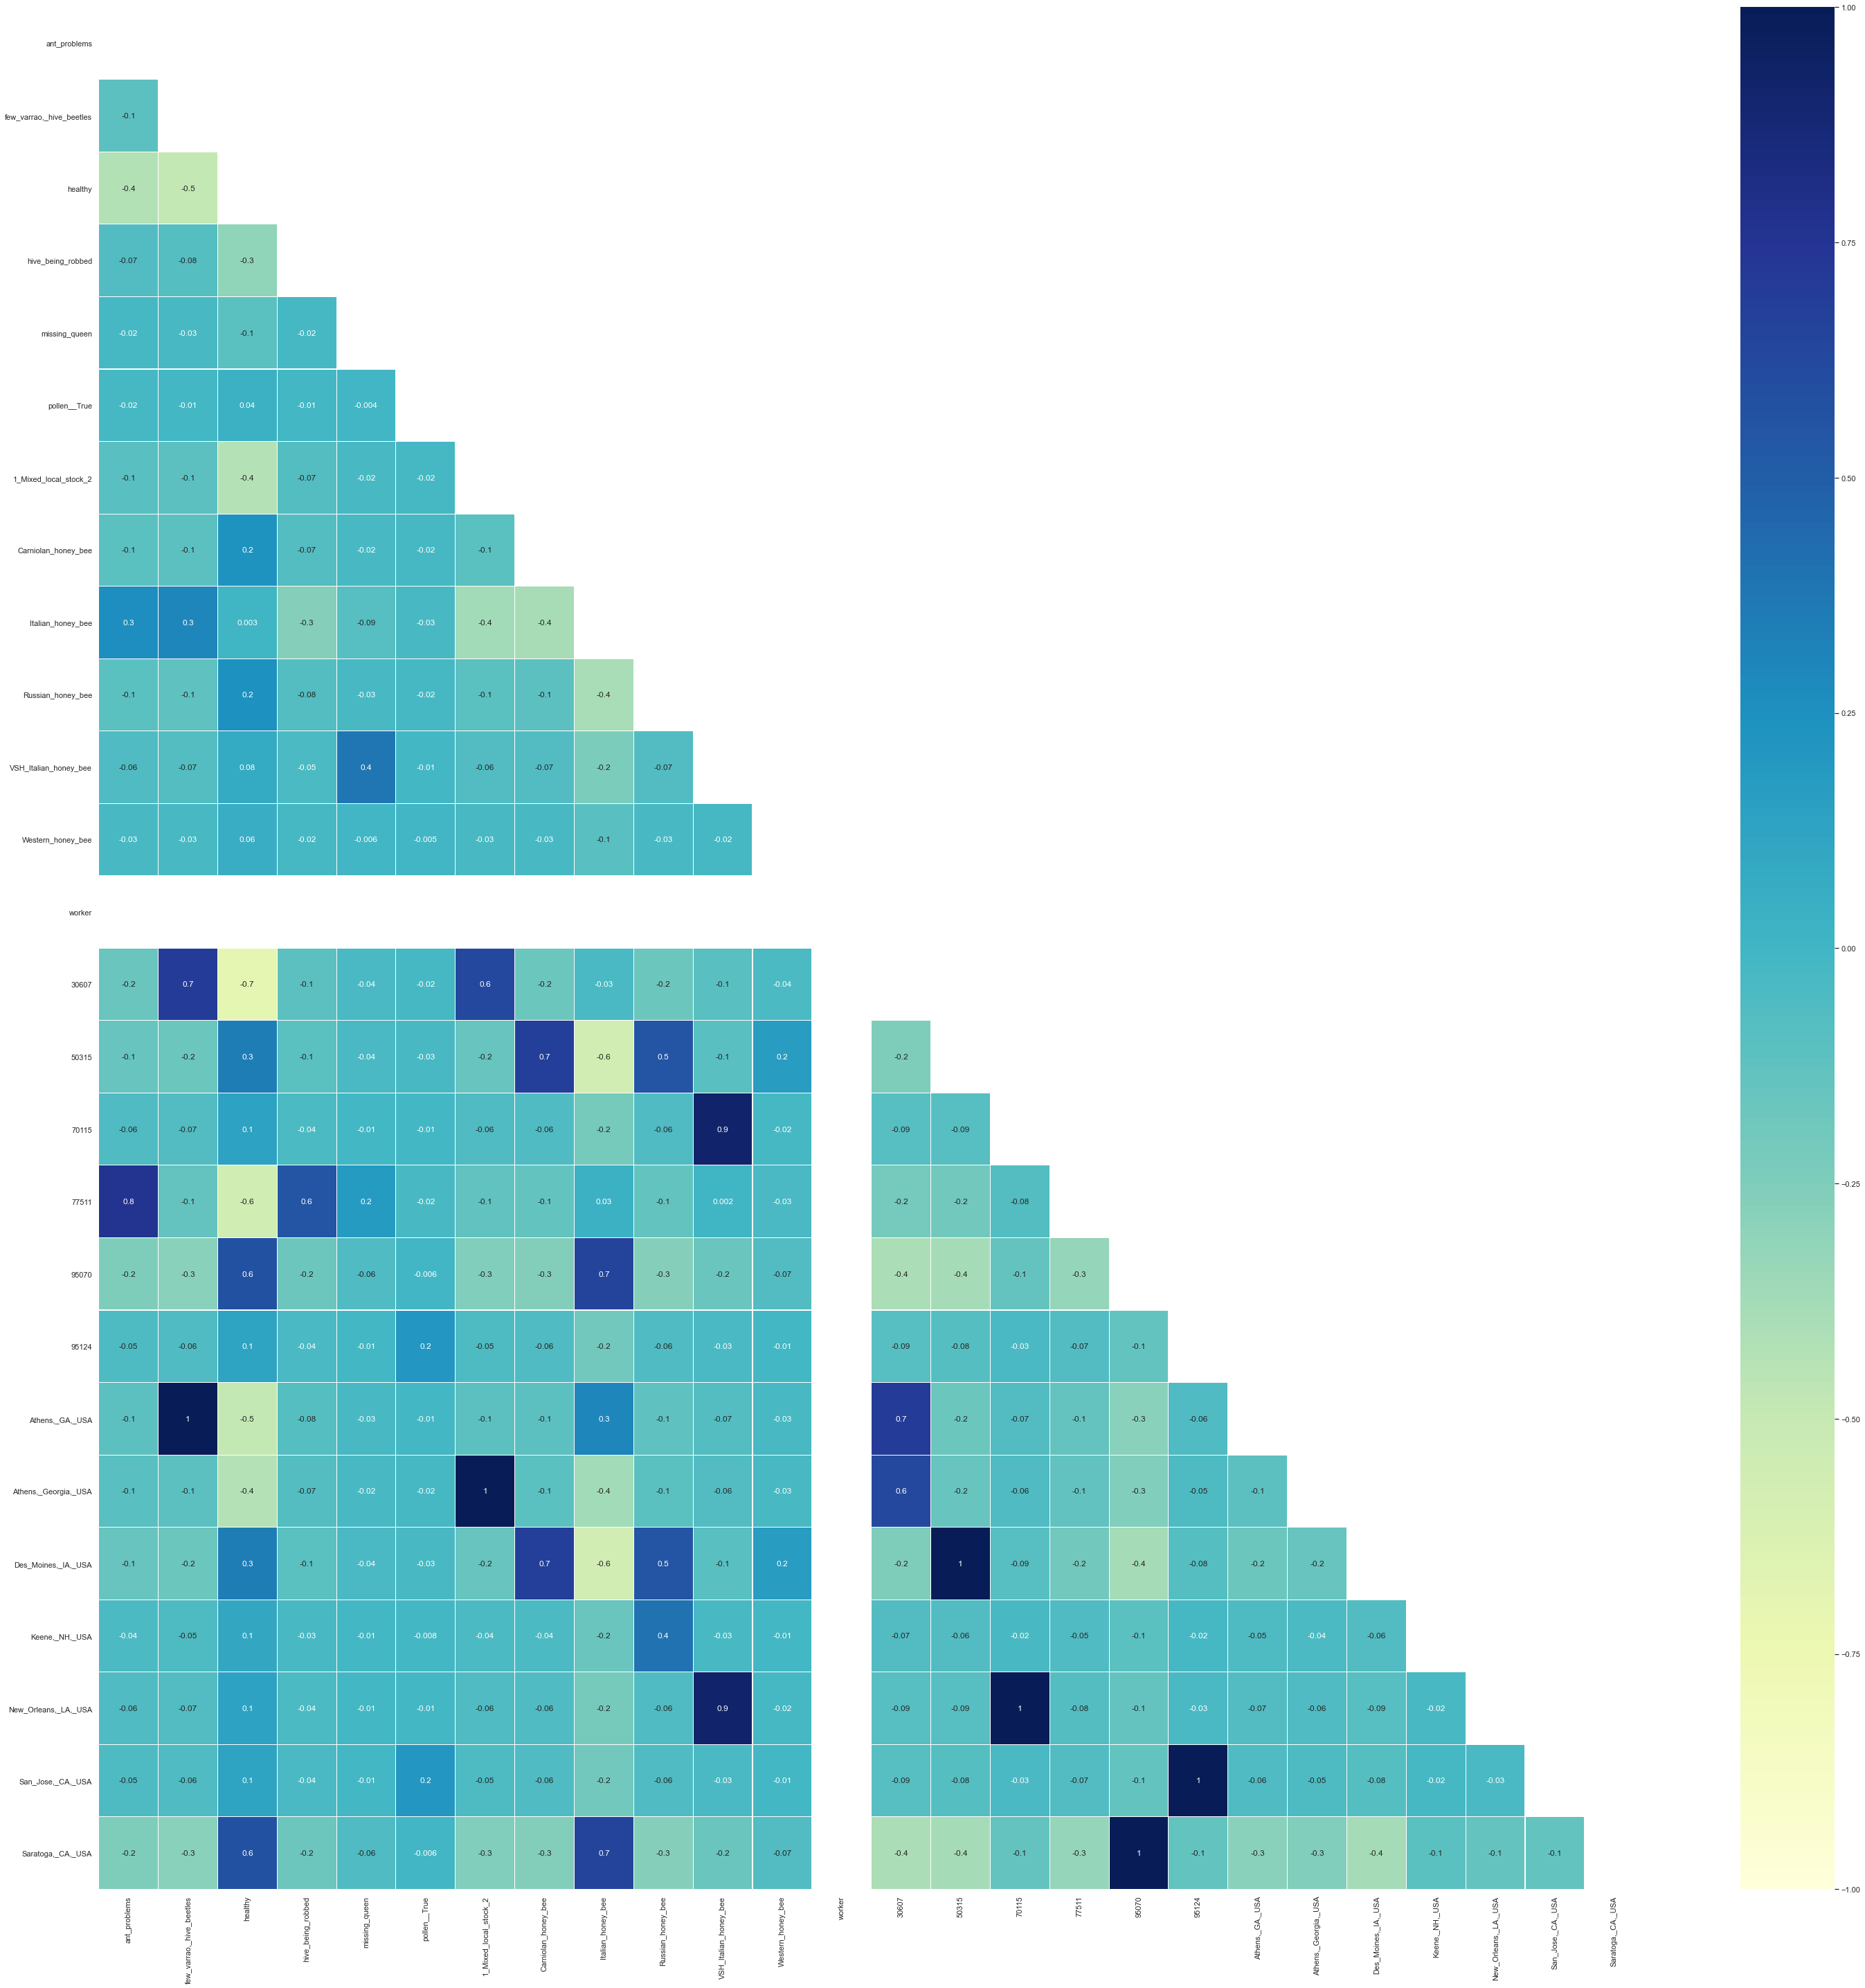

In [26]:
matrix = np.triu(bee_data_dum.corr())
plt.subplots(figsize=(50, 50))
sns.heatmap(bee_data_dum.corr(),
            mask=matrix,
            annot=True,
            fmt='.1g',
            vmin=-1,
            vmax=1,
            center=0,
            cmap='YlGnBu',
            linewidth=.1);

## Feature engineering

The categories 'few varrao, hive beetles' and 'Varroa, small hive beetles' in the column 'health' both detect Varroa mites and Hive beetles. That's why they will be combined in the next steps.

In [25]:
bee_data.health.unique()

[hive being robbed, healthy, few varrao, hive beetles, ant problems, missing queen, Varroa, Small Hive Beetles]
Categories (6, object): [hive being robbed, healthy, few varrao, hive beetles, ant problems, missing queen, Varroa, Small Hive Beetles]

In [26]:
new_cat = {
    'few varrao, hive beetles': 'varroa and hive beetles',
    'Varroa, Small Hive Beetles': 'varroa and hive beetles'
}

In [27]:
bee_data.health.replace(new_cat, inplace=True)

In [28]:
bee_data.health.astype('category', inplace=True).dtype

CategoricalDtype(categories=['ant problems', 'healthy', 'hive being robbed',
                  'missing queen', 'varroa and hive beetles'],
                 ordered=False)

Only 29 entries have 'missing queen' as health status, because I doubt that a missing queen can be detected in images of single bees I will drop those.

In [29]:
index_num = bee_data[bee_data['health'] == 'missing queen'].index

In [30]:
bee_data.drop(index_num , inplace=True)

## Looking at the pictures

In [31]:
bee_imgs = "./bee_imgs/bee_imgs/"

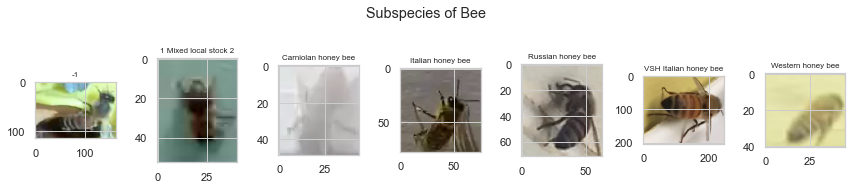

In [32]:
subspecies = bee_data['subspecies'].cat.categories
f, ax = plt.subplots(nrows=1, ncols=subspecies.size, figsize=(12, 3))
i = 0
for s in subspecies:
    if s == 'healthy':
        continue
    file = bee_imgs + bee_data[bee_data['subspecies'] == s].iloc[0]['file']
    im = imageio.imread(file)
    ax[i].imshow(im, resample=True)
    ax[i].set_title(s, fontsize=8)
    i += 1

plt.suptitle("Subspecies of Bee")
plt.tight_layout()
plt.show()

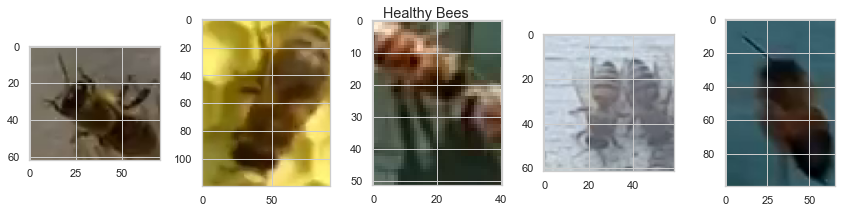

In [33]:
n = 5
healthy = bee_data[bee_data['health'] == 'healthy'].sample(n)

f, ax = plt.subplots(nrows=1, ncols=n, figsize=(12, 3))
# Read image of original size from disk, because bees['img'] contains resized numpy array
for i in range(0, 5):
    file = bee_imgs + healthy.iloc[i]['file']
    ax[i].imshow(imageio.imread(file))

plt.suptitle("Healthy Bees")
plt.tight_layout()
plt.show()

In [34]:
health_cats = set()
for d in bee_data.health:
    health_cats.add(d)

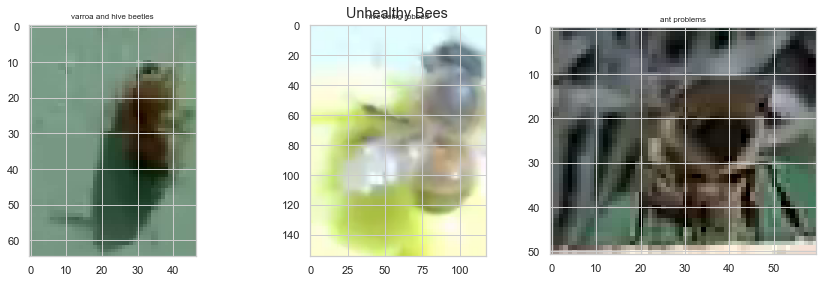

In [35]:
f, ax = plt.subplots(1, len(health_cats) - 1, figsize=(12, 4))
i = 0
for c in health_cats:
    if c == 'healthy':
        continue
    bee_img = bee_data[bee_data['health'] == c].sample(1).iloc[0]
    ax[i].imshow(imageio.imread(bee_imgs + bee_img['file']))
    ax[i].set_title(bee_img['health'], fontsize=8)
    i += 1

plt.suptitle("Unhealthy Bees")
plt.tight_layout()
plt.show()

### Images are of different sizes

In [36]:
def resize_img(file):
    """
    Read and resize img, adjust channels.
    """
    img = skimage.io.imread(bee_imgs + file)
    img = skimage.transform.resize(img, (100, 100), mode='reflect')
    img = rgb2gray(img[:, :, :3])
    img = img.flatten()
    return img

## Base model

In [37]:
 train_bee, test_bee = train_test_split(bee_data, random_state=RSEED)

In [38]:
train_bee.shape

(3857, 8)

In [39]:
X_train = np.stack(train_bee['file'].apply(resize_img)) 
y_train  = train_bee['health']

In [40]:
y_test  = test_bee['health']

In [41]:
X_test = np.stack(test_bee['file'].apply(resize_img))

In [42]:
X_train.shape

(3857, 10000)

In [43]:
X_test.shape

(1286, 10000)

In [44]:
y_train.shape

(3857,)

In [45]:
y_test.shape

(1286,)

In [46]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [47]:
param_grid = {
    'svc__C': [1, 5, 10, 50],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]
}
grid = GridSearchCV(model,
                    param_grid,
                    cv=10,
                    verbose=5,
                    scoring='f1_weighted',
                    n_jobs=-1)
%time grid.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.0min finished
Wall time: 5min 4s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 5, 10, 50],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]},
             scoring='f1_weighted', verbose=5)

In [48]:
best_param = grid.best_params_
best_param

{'svc__C': 50, 'svc__gamma': 0.005}

In [49]:
best_model = grid.best_estimator_

In [50]:
y_pred = best_model.predict(X_test)

In [51]:
ytest = y_test.to_numpy()

In [52]:
right = y_pred == ytest

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

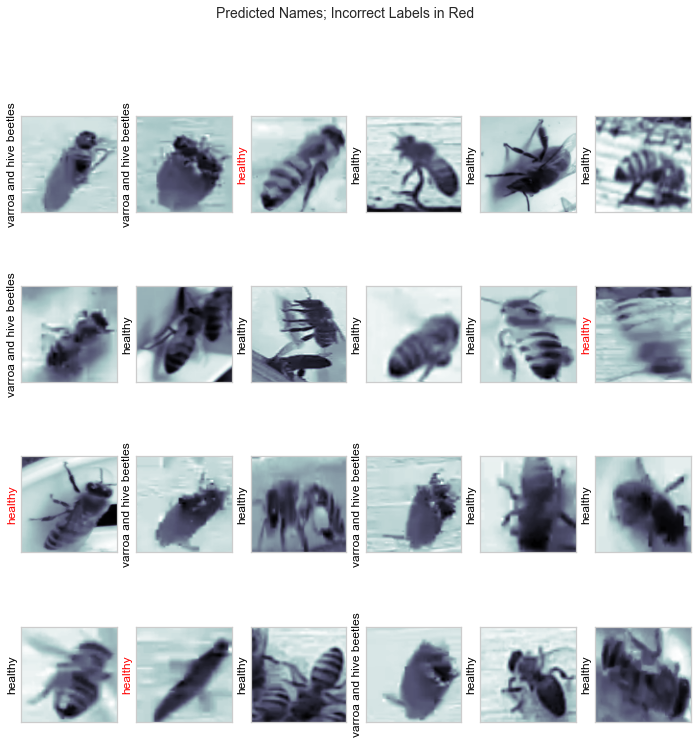

In [53]:
fig, ax = plt.subplots(4, 6, figsize=(12, 12))
counter = 0
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(100, 100), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(y_pred[i], color='black' if right[i] else 'red')

fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred));

precision    recall  f1-score   support

           ant problems       0.88      0.39      0.54       110
                healthy       0.83      0.97      0.89       845
      hive being robbed       0.38      0.05      0.09        59
varroa and hive beetles       0.90      0.82      0.86       272

               accuracy                           0.84      1286
              macro avg       0.75      0.56      0.60      1286
           weighted avg       0.83      0.84      0.82      1286



### CNN

In [55]:
def prep_img(file):
    """
    Read and resize img and channels.
    """
    img = skimage.io.imread(bee_imgs + file)
    img = skimage.transform.resize(img, (100, 100), mode='reflect')
    return img[:, :, :3]

ncat_bal = int(len(train_bee) / len(health_cats))
train_bees_bal = train_bee.groupby('health', as_index=False).apply(
    lambda g: g.sample(ncat_bal, replace=True)).reset_index(drop=True)



In [ ]:
# The same split-balance idea will be used in 2 places: subspecies and health CNN.
# Let's put this logic in function here to reuse.
def split_balance(bees, field_name):
    """ 
    Split to train, test and validation. 
    Then balance train by given field name.
    Draw plots before and after balancing.
    """
    # Split to train and test before balancing
    train_bees, test_bees = train_test_split(bees, random_state=24)

    # Split train to train and validation datasets
    # Validation for use during learning
    train_bees, val_bees = train_test_split(train_bees,
                                            test_size=0.1,
                                            random_state=24)

    #Balance by subspecies to train_bees_bal_ss dataset
    # Number of samples in each category
    ncat_bal = int(len(train_bees) / len(health_cats))
    train_bees_bal = train_bees.groupby(field_name, as_index=False).apply(
        lambda g: g.sample(ncat_bal, replace=True)).reset_index(drop=True)
    return (train_bees_bal, val_bees, test_bees)


def plot_balanced(train_bees, train_bees_bal, field_name):
    """
    Draw distribution of field by categories before and after balancing
    """
    # Plot before and after balancing
    f, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Before
    ax = train_bees[field_name].value_counts().plot(kind='bar', ax=axs[0])
    ax.set_title('%s before balancing' % field_name)
    ax.set_ylabel('Count')

    # After
    ax = train_bees_bal[field_name].value_counts().plot(kind='bar', ax=axs[1])
    ax.set_title('%s after balancing' % field_name)
    ax.set_ylabel('Count')

    plt.tight_layout()
    plt.show()


# Split/balance and plot the result
train_bees_bal, val_bees, test_bees = split_balance(bee_data, 'health')
plot_balanced(bee_data, train_bees_bal, 'health')

# Will use balanced dataset as main
train_bees = train_bees_bal

In [57]:
def prepare2train(train_bees, val_bees, test_bees, field_name):
    """
    Load images for features, drop other columns
    One hot encode for label, drop other columns
    @return: image generator, train images, validation images, test images, train labels, validation labels,
    test labels
    """
    # Bees already splitted to train, validation and test
    # Load and transform images to have equal width/height/channels.
    # read_img function is defined in the beginning to use in both health and subspecies.
    # Use np.stack to get NumPy array for CNN input

    # Train data
    train_X = np.stack(train_bees['file'].apply(prep_img))
    #train_y = to_categorical(train_bees[field_name].values)
    train_y = pd.get_dummies(train_bees[field_name], drop_first=False)

    # Validation during training data to calc val_loss metric
    val_X = np.stack(val_bees['file'].apply(prep_img))
    #val_y = to_categorical(val_bees[field_name].values)
    val_y = pd.get_dummies(val_bees[field_name], drop_first=False)

    # Test data
    test_X = np.stack(test_bees['file'].apply(prep_img))
    #test_y = to_categorical(test_bees[field_name].values)
    test_y = pd.get_dummies(test_bees[field_name], drop_first=False)

    # Data augmentation - a little bit rotate, zoom and shift input images.
    generator_train = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=
        False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=
        180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image 
        width_shift_range=
        0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=
        0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)
    generator_val = ImageDataGenerator()
    generator_train.fit(train_X)
    generator_val.fit(val_X)
    return (generator_train, generator_val, train_X, val_X, test_X, train_y,
            val_y, test_y)


#train_bees['subspecies'].cat.values[:-100]
# Call image preparation and one hot encoding
generator_train, generator_val, X_train_cnn, X_val_cnn, X_test_cnn, y_train_cnn, y_val_cnn, y_test_cnn = prepare2train(
    train_bees, val_bees, test_bees, 'health')

In [58]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(100, 100 ,3)),
    MaxPooling2D(2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(2),
    Conv2D(64, 3, padding='same', activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(y_train_cnn.columns.size, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

In [60]:
y_train_cnn_1 = np.asarray(y_train_cnn)
y_val_cnn_1 = np.asarray(y_val_cnn)

In [61]:
X_val_cnn.shape

(386, 100, 100, 3)

In [62]:
training = model.fit(generator_train.flow(X_train_cnn,y_train_cnn_1, batch_size=64),
                        epochs=15,
                        validation_data=generator_val.flow(X_val_cnn, y_val_cnn_1),
                        steps_per_epoch=25,
                        callbacks = [early_stop]
         )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 13 steps
Epoch 1/15
25/25 [==============================] - 8s 339ms/step - loss: 1.4827 - accuracy: 0.4075 - val_loss: 0.9022 - val_accuracy: 0.6943
Epoch 2/15
25/25 [==============================] - 8s 327ms/step - loss: 0.7330 - accuracy: 0.7244 - val_loss: 0.5090 - val_accuracy: 0.8472
Epoch 3/15
25/25 [==============================] - 7s 282ms/step - loss: 0.4159 - accuracy: 0.8469 - val_loss: 0.3651 - val_accuracy: 0.8627
Epoch 4/15
25/25 [==============================] - 7s 284ms/step - loss: 0.2955 - accuracy: 0.8863 - val_loss: 0.2630 - val_accuracy: 0.9223
Epoch 5/15
25/25 [==============================] - 7s 279ms/step - loss: 0.2266 - accuracy: 0.9121 - val_loss: 0.1709 - val_accuracy: 0.9482
Epoch 6/15
25/25 [==============================] - 7s 288ms/step - loss: 0.2008 - accuracy: 0.9275 - val_loss: 0.2631 - val_accuracy: 0.9326
Epoch 7/15
25/25 [==============================] - 7s 2

In [79]:
y_pred_cnn = model.predict(X_test_cnn)

In [ ]:
def visualize_layer_kernels(img, conv_layer, title):
    """
    Displays how input sample image looks after convolution by each kernel.
    """
    # Extract kernels from given layer
    weights1 = conv_layer.get_weights()
    kernels = weights1[0]
    kernels_num = kernels.shape[3]

    # Each row contains 3 images: kernel, input image, output image
    f, ax = plt.subplots(kernels_num, 3, figsize=(7, kernels_num * 2))

    for i in range(0, kernels_num):
        # Get kernel from the layer and draw it
        kernel = kernels[:, :, :3, i]
        ax[i][0].imshow((kernel * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][0].set_title("Kernel %d" % i, fontsize=9)

        # Get and draw sample image from test data
        ax[i][1].imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][1].set_title("Before", fontsize=8)

        # Filtered image - apply convolution
        img_filt = scipy.ndimage.filters.convolve(img, kernel)
        ax[i][2].imshow((img_filt * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][2].set_title("After", fontsize=8)

    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

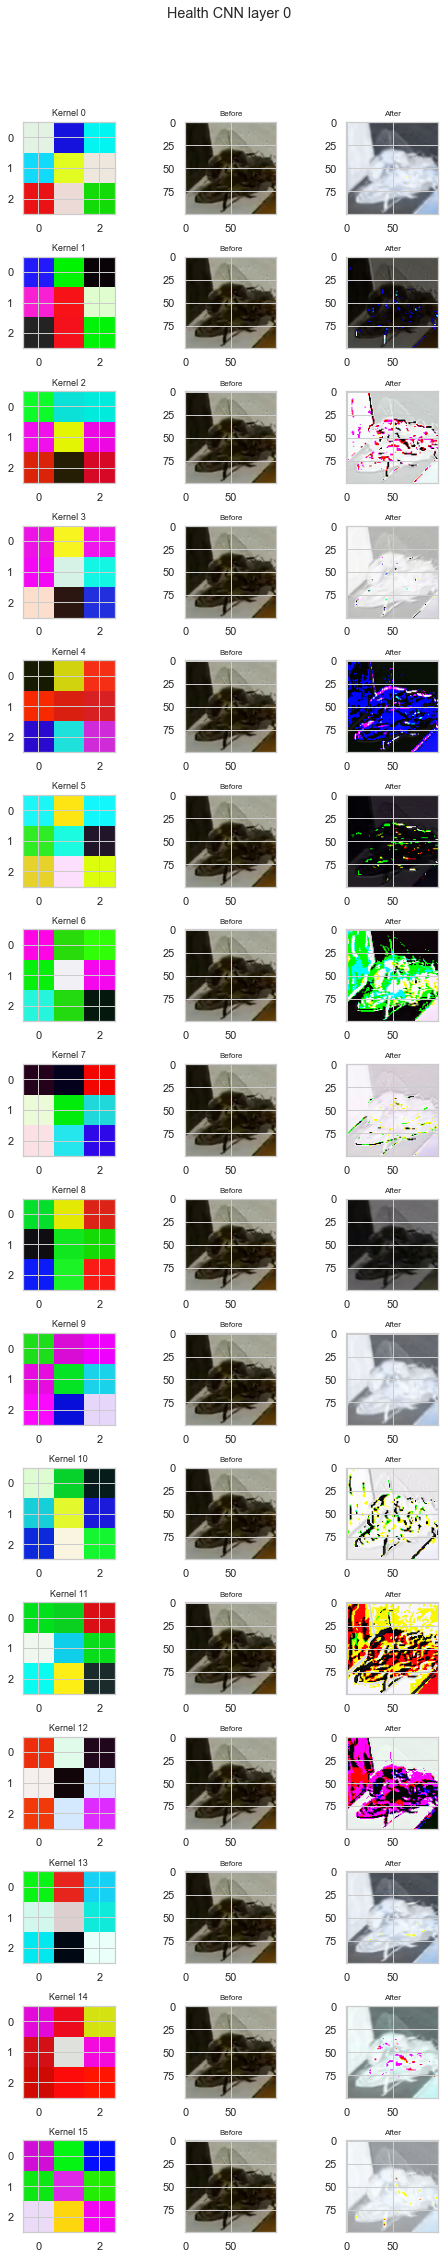

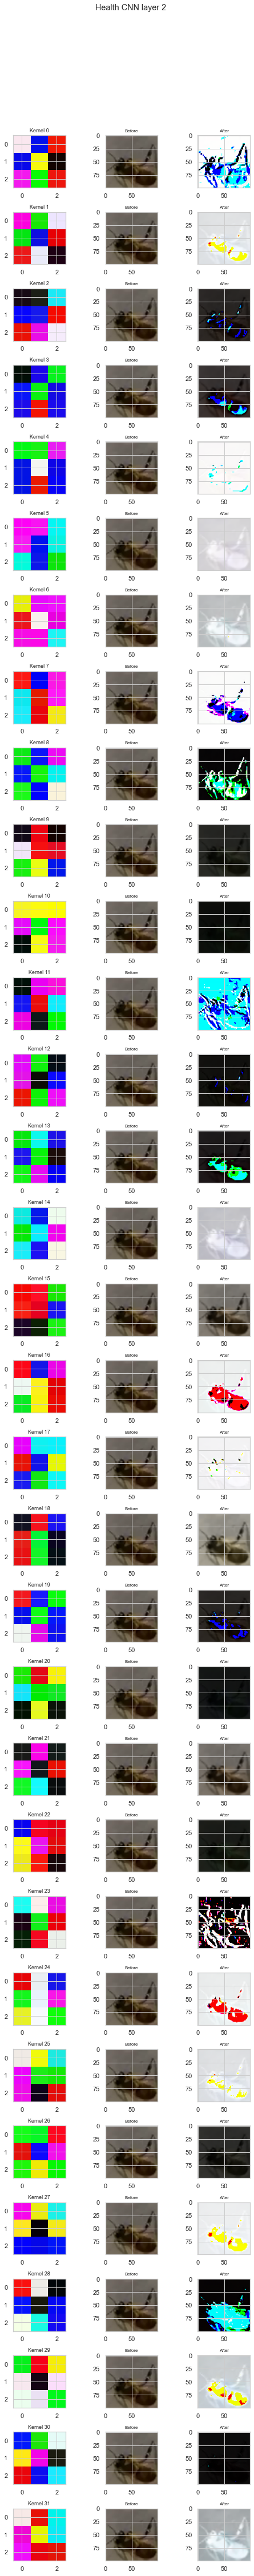

In [67]:
# Take sample image to visualize convolution
idx = random.randint(0,len(X_test_cnn)-1)
img = X_test_cnn[idx,:,:,:]
#img = img[:,:,:]
# Take 1st convolutional layer and look at it's filters
conv1 = model.layers[0]
visualize_layer_kernels(img, conv1, "Health CNN layer 0")

# Take sample image to visualize convolutoin
idx = random.randint(0,len(X_test_cnn)-1)
img = X_test_cnn[idx,:,:,:]
# Take another convolutional layer and look at it's filters
conv2 = model.layers[2]
visualize_layer_kernels(img, conv2, "Health CNN layer 2")

In [ ]:
def eval_model(training, model, test_X, test_y, field_name):
    """
    Model evaluation: plots, classification report
    """
    ## Trained model analysis and evaluation
    f, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax[0].plot(training.history['loss'], label="Loss")
    ax[0].plot(training.history['val_loss'], label="Validation loss")
    ax[0].set_title('%s: loss' % field_name)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Accuracy
    ax[1].plot(training.history['accuracy'], label="Accuracy")
    ax[1].plot(training.history['val_accuracy'], label="Validation accuracy")
    ax[1].set_title('%s: accuracy' % field_name)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    # Accuracy by subspecies
    test_pred = model.predict(test_X)

    #acc_by_subspecies = np.logical_and(
    #    (test_pred > 0.5), test_y).sum() / test_y.sum()
    #acc_by_subspecies.plot(kind='bar', title='Accuracy by %s' % field_name)
    #plt.ylabel('Accuracy')
    #plt.show()

    # Print metrics
    print("Classification report")
    test_pred = np.argmax(test_pred, axis=1)
    test_truth = np.argmax(test_y.values, axis=1)
    print(
        metrics.classification_report(test_truth,
                                      test_pred,
                                      target_names=test_y.columns))

    # Loss function and accuracy
    test_res = model.evaluate(test_X, test_y.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

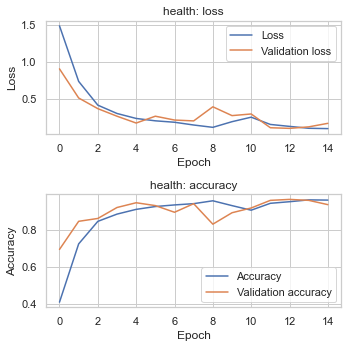

Classification report
                         precision    recall  f1-score   support

           ant problems       0.80      1.00      0.89       113
                healthy       0.99      0.89      0.93       861
      hive being robbed       0.64      0.96      0.77        70
varroa and hive beetles       0.86      0.95      0.90       242

               accuracy                           0.91      1286
              macro avg       0.82      0.95      0.87      1286
           weighted avg       0.93      0.91      0.92      1286

Loss function: 0.2191404850652346, accuracy: 0.91213065


In [72]:
eval_model(training, model, X_test_cnn, y_test_cnn, 'health')

In [73]:
test_truth = np.argmax(y_test_cnn.values, axis=1)

In [74]:
y_pred_cnn_final = np.argmax(y_pred_cnn, axis=1)

In [75]:
right_cnn = y_pred_cnn_final == test_truth

In [76]:
classes_dic = {
    0: "Ant Problem",
    1: 'Healthy',
    2: 'Hive Beeing Robbed',
    3: 'Varroa Mites or Hive Beetles'
}

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

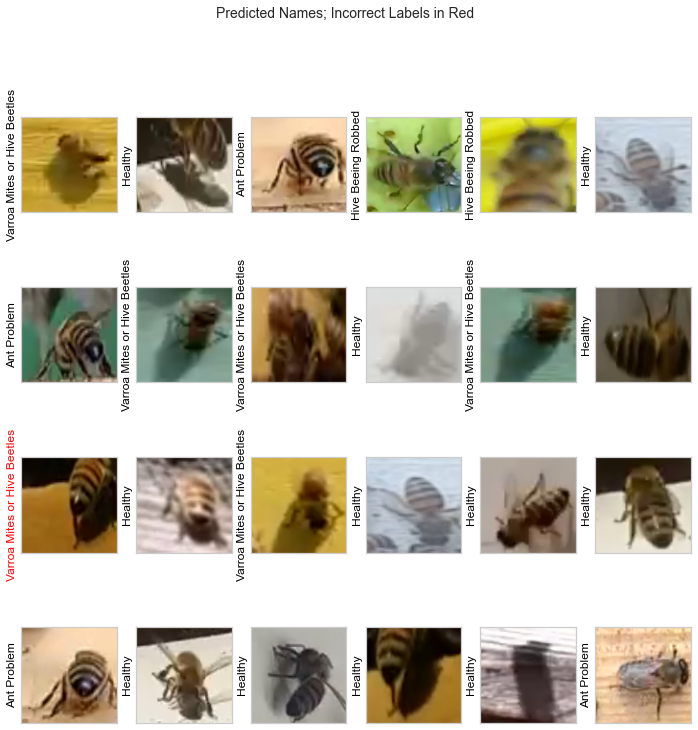

In [77]:
fig, ax = plt.subplots(4, 6, figsize=(12, 12))
counter = 0
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test_cnn[i].reshape(100, 100, 3), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(classes_dic[y_pred_cnn_final[i]],
                   color='black' if right_cnn[i] else 'red')

fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)